In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr
import numpy as np
import gseapy as gp
from scipy.sparse import csr_matrix
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [2]:
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_qc_filtered.h5ad")


In [3]:
NE_genes = ['KIF1A', 'GNAO1','DPYSL5','SYP','CHGA','KIF5C','SCAMP5','TUBB2B','SCG3','GNG4','CRMP1','RUNDC3A','CHRNB2','BEX1','PGBD5','CHGB','RAB39A', 'NCAM1','TMEM198','AP3B2','UNC13A','MAPK8IP1','SNAP25','SOGA3','INSM1']
non_NE_genes = ['HFE','ITGB4','IL18','ANXA3','CAV2','GPRC5A','AHNAK','ADGRG6','IFITM3','CAV1','EPHA2','GPX8','LGALS3','CCN1','RHBDF1','NT5E','WWTR1','NABP1','OSMR','YAP1','TGFBR2','ANXA1','S100A16','MYOF','EMP1']

In [4]:
zhang_ne_gene_sets = {
    'NE': NE_genes,
    'non_NE': non_NE_genes
}

In [5]:
sclc_a_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_a_ccle_degs.txt"
sclc_n_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_n_ccle_degs.txt"
sclc_p_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_p_ccle_degs.txt"

In [6]:
sclc_a_degs = []
sclc_n_degs = []
sclc_p_degs = []


with open(sclc_a_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_a_degs.append(ll)

with open(sclc_n_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_n_degs.append(ll)

with open(sclc_p_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_p_degs.append(ll)

In [7]:
sclc_a_degs.sort()
sclc_n_degs.sort()
sclc_p_degs.sort()

In [8]:
sclc_subtype_gene_sets = {
    'A': sclc_a_degs,
    'N': sclc_n_degs,
    'P':sclc_p_degs
}

In [22]:
chan_adata

AnnData object with n_obs × n_vars = 49685 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'NE_ssgsea', 'non_NE_ssgsea', 'A_ssgsea', 'N_ssgsea', 'P_ssgsea'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed', 'diffmap_evals', 'neighbors', 'num_components', 'pa

In [40]:
tumor_expr_matrix_df = pd.DataFrame(chan_adata.layers['imputed_normalized'], index=chan_adata.obs_names, columns=chan_adata.var_names)

In [41]:
tumor_expr_matrix_df

index,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADACL2,AADACL4,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Cell,,,,,,,,,,,,,,,,,,,,,
RU1215_192110488599350,0.818766,2.030145e-06,0.006040,6.556134e-04,0.001248,0.253468,0.172105,0.000000e+00,0.000000,0.158761,...,0.067361,0.197912,0.006289,0.057270,0.076331,0.006116,0.248095,0.180062,0.083676,0.221433
RU1152_130751366121844,0.643530,4.353751e-04,0.000001,2.453256e-10,0.012063,0.442461,0.357188,0.000000e+00,0.000000,0.048457,...,0.092338,0.165467,0.029953,0.066405,0.197291,0.016003,0.556244,0.001161,0.163645,0.317989
RU1231A_120703424294126,0.216781,5.709375e-04,0.012124,2.415050e-06,0.027692,0.313640,0.403919,0.000000e+00,0.000009,0.046848,...,0.075933,0.943792,0.014245,0.052231,0.170280,0.030277,0.358111,0.074952,0.077617,0.390668
RU1322A_LN_133924258008493,0.002698,3.099080e-04,0.001524,8.853608e-05,0.000008,0.246715,0.117706,8.097523e-03,0.000000,0.128617,...,0.060977,0.118816,0.017451,0.058226,0.148224,0.033260,0.234685,0.095208,0.083569,0.412853
RU1181B_169649541863334,0.770710,8.954622e-01,0.000878,1.369728e-04,0.108603,0.638461,0.434471,0.000000e+00,0.000000,0.045703,...,0.175597,0.199264,0.034538,0.069232,0.407981,0.044829,0.457972,0.148332,0.294533,0.488674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RU1144_LN_191210559064798,0.653350,1.750352e-04,0.027032,1.531295e-05,0.004878,0.395467,0.260500,3.335518e-07,0.000000,0.068818,...,0.424602,0.466026,0.012383,0.028583,0.182652,0.018590,0.207072,0.143023,0.022104,0.176993
RU1231A_133921857226469,0.220391,3.258149e-05,0.067362,4.868693e-04,0.008898,0.329007,0.462212,2.000022e-06,0.000006,0.076229,...,0.255673,2.081074,0.013777,0.063636,0.167323,0.040308,0.504005,0.071991,0.108618,0.462514
RU1293A_169220299503989,0.387914,8.102062e-07,0.001650,3.447141e-04,0.114574,0.166000,0.191102,3.113307e-07,0.000000,0.005321,...,0.049576,0.225427,0.073581,0.054845,0.381610,0.008750,0.257630,0.120435,0.107073,0.504177


In [10]:
gs_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=zhang_ne_gene_sets,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [11]:
gs_subtype_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=sclc_subtype_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [12]:
ssgsea_scores = gs_res.results
ssgsea_subtype_scores = gs_subtype_res.results

In [13]:
nes_ne = []
nes_non_ne = []
cells = []

for cell_id, result in ssgsea_scores.items():
    cells.append(cell_id)
    nes_ne.append(result['NE']['nes'])
    nes_non_ne.append(result['non_NE']['nes'])  
    
nes_df = pd.DataFrame({
    'NE_ssgsea': nes_ne,
    'non_NE_ssgsea': nes_non_ne
}, index=cells)

In [14]:
sclca = []
sclcn = []
sclcp = []
cells1 = []

for cell_id, result in ssgsea_subtype_scores.items():
    cells1.append(cell_id)
    sclca.append(result['A']['nes'])
    sclcn.append(result['N']['nes'])
    sclcp.append(result['P']['nes'])
    
sclc_subtype_df = pd.DataFrame({
    'A_ssgsea': sclca,
    'N_ssgsea': sclcn,
    'P_ssgsea': sclcp
}, index=cells1)

In [15]:
for i in range(len(cells)):
    idx = chan_adata.obs_names.get_loc(cells[i])
    chan_adata.obs.loc[cells[i], 'NE_ssgsea'] = nes_ne[i]
    chan_adata.obs.loc[cells[i], 'non_NE_ssgsea'] = nes_non_ne[i]

    idx2 = chan_adata.obs_names.get_loc(cells1[i])
    chan_adata.obs.loc[cells1[i], 'A_ssgsea'] = sclca[i]
    chan_adata.obs.loc[cells1[i], 'N_ssgsea'] = sclcn[i]
    chan_adata.obs.loc[cells1[i], 'P_ssgsea'] = sclcp[i]

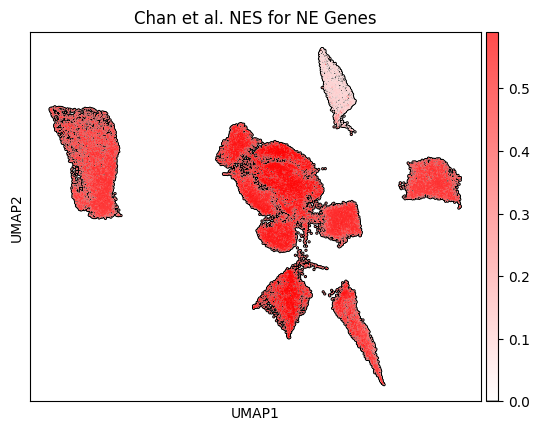

In [73]:
values = chan_adata.obs['NE_ssgsea'].astype(float)
vmin = 0
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(chan_adata, color='NE_ssgsea', cmap=cmap,title='Chan et al. NES for NE Genes',show=False,vmin=vmin, vmax=vmax,add_outline=True,outline_width=(1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_ne_score.png", dpi=600,bbox_inches='tight')

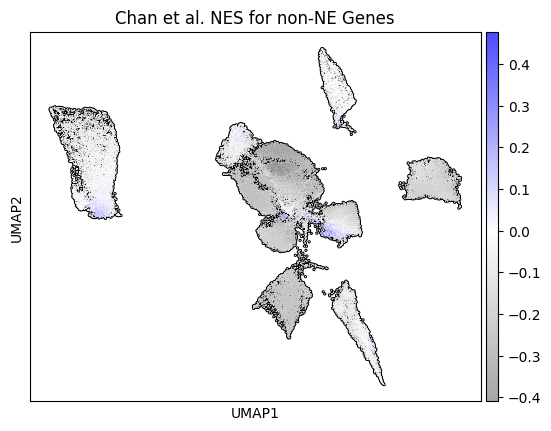

In [74]:
values = chan_adata.obs['non_NE_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(chan_adata, color='non_NE_ssgsea', cmap=cmap,title='Chan et al. NES for non-NE Genes',show=False,vmin=vmin, vmax=vmax,add_outline=True,outline_width=(1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_non_ne_score.png", dpi=600,bbox_inches='tight')

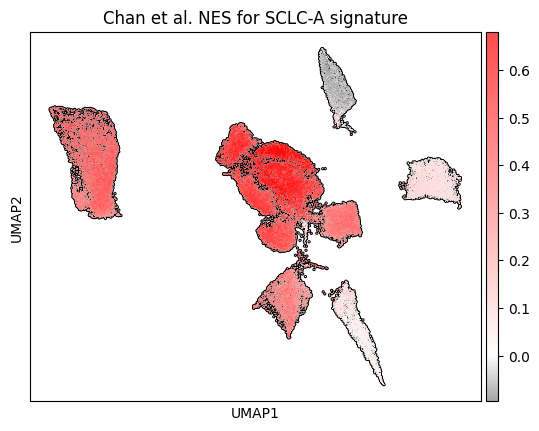

In [69]:
values = chan_adata.obs['A_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(chan_adata, color='A_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-A signature',vmin=vmin, vmax=vmax,show=False,add_outline=True,outline_width=(1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_a_score.png", dpi=600,bbox_inches='tight')

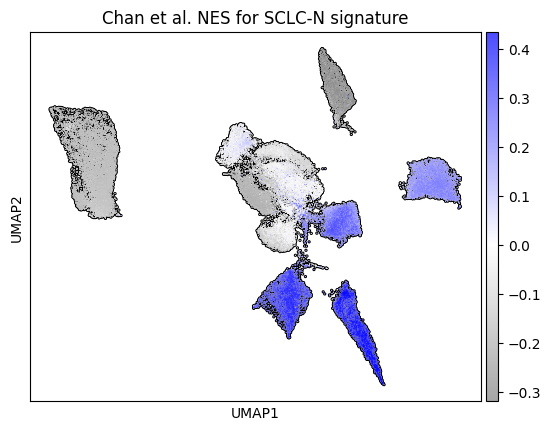

In [68]:
values = chan_adata.obs['N_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(chan_adata, color='N_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-N signature',vmin=vmin, vmax=vmax,show=False,add_outline=True,outline_width=(1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_n_score.png", dpi=600,bbox_inches='tight')

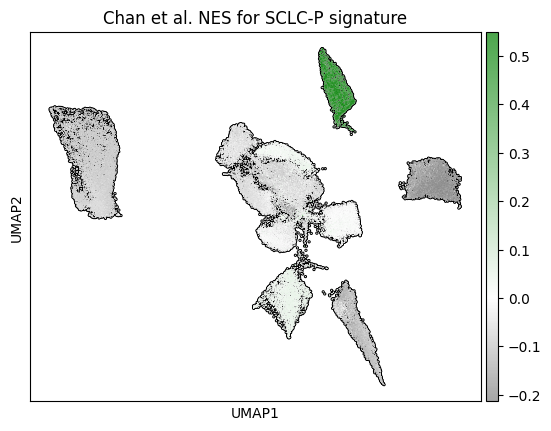

In [67]:
values = chan_adata.obs['P_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('grey_to_green', colors)

sc.pl.umap(chan_adata, color='P_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-P signature',vmin=vmin, vmax=vmax,show=False,add_outline=True,outline_width=(1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_p_score.png", dpi=600,bbox_inches='tight')

In [19]:
chan_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_subtyped.h5ad")